<a href="https://colab.research.google.com/github/kallepalomaki/cyber-ml/blob/main/cyber_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget "https://zenodo.org/record/6463389/files/ALLFLOWMETER_HIKARI2021.csv.zip"
!unzip ALLFLOWMETER_HIKARI2021.csv.zip

--2022-12-08 06:46:59--  https://zenodo.org/record/6463389/files/ALLFLOWMETER_HIKARI2021.csv.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68403081 (65M) [application/octet-stream]
Saving to: ‘ALLFLOWMETER_HIKARI2021.csv.zip’

ALLFLOWMETER_HIKARI 100%[===================>]  65.23M   523KB/s    in 2m 17s  

2022-12-08 06:49:17 (489 KB/s) - ‘ALLFLOWMETER_HIKARI2021.csv.zip’ saved [68403081/68403081]

Archive:  ALLFLOWMETER_HIKARI2021.csv.zip
  inflating: ALLFLOWMETER_HIKARI2021.csv  


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from datetime import datetime


In [ ]:
#m = nn.Conv1d(16, 33, 3, stride=2)
#input = torch.randn(20, 16, 3)
#output = m(input)

In [ ]:
df=pd.read_csv('ALLFLOWMETER_HIKARI2021.csv')


In [ ]:
df.shape

(555278, 88)

In [ ]:
targets=df['Label'].values
inputs=df.drop(['uid', 'originp', 'originh', 'responh', 'responp', 'traffic_category','Label'],axis=1)

#from sklearn.datasets import load_breast_cancer

# load the data
#data = load_breast_cancer()

#inputs=data.data
#targets=data.target

In [ ]:
scaler=StandardScaler()
scaler.fit(inputs)
inputs=scaler.transform(inputs)

In [ ]:
inputs=inputs[:,2:]
inputs.shape

(555278, 79)

In [ ]:
input_means=np.mean(inputs, axis=0)
input_std=np.std(inputs,axis=0)

In [ ]:
len(inputs)

555278

In [ ]:
X=[]
Y=[]
T=4
D=inputs.shape[1]
for t in range(len(inputs)):
  X_conv=[]
  for it in range(T):
    x=np.pad(inputs[t],(it, T-it))
    X_conv.append(x)
    #print(x.shape) 
    
  X.append(X_conv)
  #print(np.array(X).shape)
  Y.append(targets[t])

X=np.array(X).reshape(len(inputs),-1,T)
Y=np.array(Y)
#Y=np.array(Y).reshape(-1,1)

inputs=X
targets=Y
print(inputs.shape)
print(targets.shape)
inputs, targets=shuffle(inputs, targets)
train_len=int(len(targets)*0.8)

(555278, 83, 4)
(555278,)


In [ ]:
D=X.shape[1]
print(X.shape)
print(Y.shape)

(555278, 83, 4)
(555278,)


In [ ]:
train_inputs=torch.from_numpy(inputs[:train_len].astype(np.float32))
test_inputs=torch.from_numpy(inputs[train_len:].astype(np.float32))

#train_targets=torch.from_numpy(targets[:train_len])
#test_targets=torch.from_numpy(targets[train_len:])

In [ ]:
train_targets=torch.from_numpy(targets[:train_len].astype(np.float32).reshape(-1,1))
test_targets=torch.from_numpy(targets[train_len:].astype(np.float32).reshape(-1,1))

In [ ]:
class Model(nn.Module):
  def __init__(self, D, num_hidden=512):
    super(Model, self).__init__()
    self.D=D

    #self.linear_stack = nn.Sequential(
            #nn.Linear(D, num_hidden),
    #        nn.Conv1d(D,num_hidden, kernel_size=3),
     #       nn.AvgPool1d(3),
            #nn.ReLU(),
     #       nn.Linear(num_hidden, 1),
      #  )
    self.num_hidden=num_hidden
    self.conv=nn.Conv1d(D, num_hidden,kernel_size=3)
    self.relu=nn.ReLU()
    self.avgpool=nn.AvgPool1d(2)
    self.lin2=nn.Linear(num_hidden, num_hidden)
    self.relu2=nn.ReLU()
    self.lin=nn.Linear(num_hidden, 1)
    
  def forward(self, input_data):   
    #logits=self.linear_stack(input_data)
    #print("input_shape", input_data.shape)
    logits=self.conv(input_data)
    #print("logits_shape", logits.shape)
    logits=self.relu(logits)
    logits=self.avgpool(logits).reshape(-1,self.num_hidden)
    #print("logits_shape after pooling", logits.shape)
    logits=self.lin2(logits)
    logits=self.relu2(logits)
    logits=self.lin(logits)
    return logits

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model=Model(D=D, num_hidden=100)
model.to(device)

Model(
  (conv): Conv1d(83, 100, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (lin): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
criterion=nn.BCEWithLogitsLoss()  #MSELoss()# CrossEntropyLoss() #nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #BCELoss #nn.BCEWithLogitsLoss
optimizer=torch.optim.Adam(model.parameters())

In [ ]:
train_data=TensorDataset(train_inputs, train_targets)
test_data=TensorDataset(test_inputs, test_targets)
batch_size=512
train_loader=DataLoader(dataset=train_data,
                        batch_size=batch_size,
                        shuffle=False)
test_loader=DataLoader(dataset=test_data,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
def train(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses=np.zeros(epochs)
  test_losses=np.zeros(epochs)
  for it in range(epochs):
    t0=datetime.now()
    train_loss=[]
    for i_inputs, t_targets in train_loader:
      i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)
      model.zero_grad()
      pred=model(i_inputs)
      #print(pred_ratings.shape, targets.shape)
      loss=criterion(pred, t_targets.reshape(-1,1))
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_losses[it]=np.mean(train_loss)
    test_loss=[]  
    for i_inputs, t_targets in test_loader:
      i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)
      model.zero_grad()
      pred=model(i_inputs)
      loss=criterion(pred, t_targets.reshape(-1,1))
      test_loss.append(loss.item())
    test_losses[it]=np.mean(test_loss)
    print("iteration: ", it, "/", epochs, " train loss: ", train_losses[it], "test loss: ", test_losses[it])
  
  return train_losses, test_losses 

In [ ]:
train_losses, test_losses=train(model, criterion, optimizer, train_loader, test_loader, 100)

iteration:  0 / 100  train loss:  0.12455906803947166 test loss:  0.12436662909622016
iteration:  1 / 100  train loss:  0.1244525541529952 test loss:  0.1241301541229547
iteration:  2 / 100  train loss:  0.12444583649322184 test loss:  0.12431588786126282
iteration:  3 / 100  train loss:  0.12429340193176874 test loss:  0.123779718433657
iteration:  4 / 100  train loss:  0.12423741058682516 test loss:  0.1237233710316469
iteration:  5 / 100  train loss:  0.12407272206061447 test loss:  0.12339597363625804
iteration:  6 / 100  train loss:  0.12407757220832709 test loss:  0.12330167136296699
iteration:  7 / 100  train loss:  0.12393576832067582 test loss:  0.12325173558040697
iteration:  8 / 100  train loss:  0.1239166923880165 test loss:  0.12321022492811977
iteration:  9 / 100  train loss:  0.12381878225690758 test loss:  0.12319748594601583
iteration:  10 / 100  train loss:  0.12378963747400842 test loss:  0.12325474482527526
iteration:  11 / 100  train loss:  0.12372097206486535 test

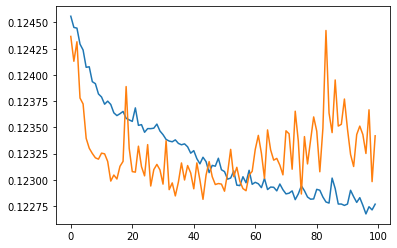

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
train_list=[]
test_list=[]
for i_inputs, t_targets in train_loader:
  i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)

  pred_train = model(i_inputs)
  pred_train = (pred_train.detach().cpu().numpy() > 0.5)
  train_list.append(np.mean(t_targets.detach().cpu().numpy() == pred_train))
  #print(train_acc)
#  pred_test = model(X_test)
#  p_test = (p_test.numpy() > 0)
#  test_acc = np.mean(y_test.numpy() == p_test)
#print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

for i_inputs, t_targets in test_loader:
  i_inputs, t_targets=i_inputs.to(device), t_targets.to(device)

  pred_test = model(i_inputs)
  pred_test = (pred_test.detach().cpu().numpy() > 0.5)
  test_list.append(np.mean(t_targets.detach().cpu().numpy() == pred_test))
  #print(train_acc)
#  pred_test = model(X_test)
#  p_test = (p_test.numpy() > 0)
#  test_acc = np.mean(y_test.numpy() == p_test)
#print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


In [ ]:
print(np.mean(np.array(train_list)))
print(np.mean(np.array(test_list)))

0.9324726122094456
0.9324398140791356
